# Experiment: Train Bidirectional LSTM Model

## Confirm Environment

In [1]:
!conda info


     active environment : northeastern
    active env location : /home/curtis/anaconda3/envs/northeastern
            shell level : 2
       user config file : /home/curtis/.condarc
 populated config files : /home/curtis/anaconda3/.condarc
          conda version : 24.9.2
    conda-build version : 24.9.0
         python version : 3.12.7.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=skylake
                          __conda=24.9.2=0
                          __glibc=2.39=0
                          __linux=6.6.87.2=0
                          __unix=0=0
       base environment : /home/curtis/anaconda3  (writable)
      conda av data dir : /home/curtis/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://r

## Setup and Imports

In [2]:
from emolex.preprocessing import load_mental_health_sentiment_dataset, clean_text, encode_sentiment_labels, split_data, dl_text_vectorization
from emolex.dl_models import bilstm_model 
from emolex.train import train_dl_model
from emolex.evaluation import plot_training_history, generate_confusion_matrix, generate_classification_report
from emolex.utils import detect_and_set_device

2025-07-02 15:44:41.133962: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 15:44:41.158193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751485481.186665   47736 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751485481.192886   47736 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751485481.210951   47736 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Device Setup

In [3]:
# Detect and set up GPU or use CPU
device_used = detect_and_set_device()
print(f"TensorFlow is configured to use: {device_used}")

No GPU devices found despite TensorFlow being built with CUDA. Using CPU.
TensorFlow is configured to use: CPU


2025-07-02 15:44:48.045017: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Load Data

In [4]:
df = load_mental_health_sentiment_dataset()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51093 entries, 0 to 51092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    51093 non-null  object
 1   label   51093 non-null  object
dtypes: object(2)
memory usage: 798.5+ KB


,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


## Clean Data

In [5]:
print(f"\n--- Cleaning Text ---")
df['clean_text'] = df["text"].apply(clean_text)
print("Text cleaning complete. Sample cleaned text:")
print("\n", df[["text", "clean_text"]].sample(5))


--- Cleaning Text ---
Text cleaning complete. Sample cleaned text:

                                                     text  \
49524  any negative response makes me genuinely conte...   
38195  i m miserable most of the time but life is onl...   
13001  Is there anyway to block search engines from g...   
35861                           @TairrieB recorded what?   
42767      going to sleep now johnny just died on the oc   

                                              clean_text  
49524  negative response make genuinely contemplate s...  
38195  miserable time life bearable cat think favouri...  
13001  anyway block search engine going suicidal hotl...  
35861                                  tairrieb recorded  
42767                         going sleep johnny died oc  


## Encode Labels

In [6]:
print(f"\n--- Encoding Labels ---")
df, encoder = encode_sentiment_labels(df)
print("Label encoding complete. Sample encoded labels:")
print("\n", df[['label', 'label_encoded']].sample(5))


--- Encoding Labels ---
Label Encoding Map: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}
Label encoding complete. Sample encoded labels:

             label  label_encoded
7358     Suicidal              6
11856  Depression              2
43773      Normal              3
26743  Depression              2
36305      Normal              3


## Train-Test Split

In [7]:
print("\n--- Perform Train-Test Split ---")
X_train_raw, X_test_raw, y_train, y_test = split_data(df) 
print(f"Train set size: {len(X_train_raw)} samples")
print(f"Test set size: {len(X_test_raw)} samples")


--- Perform Train-Test Split ---
Train set size: 40874 samples
Test set size: 10219 samples


## Vectorization

In [8]:
print("\n--- Performing Text Vectoriation ---")
X_train_pad_filtered, X_test_pad_filtered, y_train_filtered, y_test_filtered = dl_text_vectorization(X_train_raw, X_test_raw, y_train, y_test)
print("Vecorization complete.")


--- Performing Text Vectoriation ---
Original X_train shape: (40874,), Filtered X_train_pad shape: (40807, 100)
Original X_test shape: (10219,), Filtered X_test_pad shape: (10205, 100)
Vecorization complete.


## Build Model

In [9]:
print("\n--- Build Model ---")
model = bilstm_model(num_classes=len(encoder.classes_), vocab_size=10000, max_len=100)


--- Build Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,711,879 (6.53 MB)

 Trainable params: 1,711,879 (6.53 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [10]:
print("\n--- Training Model ---")
model, history = train_dl_model(model, X_train_pad_filtered, y_train_filtered, X_test_pad_filtered, y_test_filtered, epochs=20)


--- Training Model ---
Starting model training for 2 epochs with batch size 32...
Epoch 1/2
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 434s 329ms/step - accuracy: 0.5501 - loss: 1.1401 - val_accuracy: 0.6935 - val_loss: 0.7486
Epoch 2/2
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 437s 342ms/step - accuracy: 0.7008 - loss: 0.7334 - val_accuracy: 0.7370 - val_loss: 0.6608
Restoring model weights from the end of the best epoch: 2.
Model training complete.


## Evaluate Model


--- Plot Training History ---


/mnt/c/grad_school/northeastern/ie7500/project/NLP_Project/src/emolex/evaluation.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Training and Validation Accuracy (or Loss)'}, xlabel='Epochs'>)

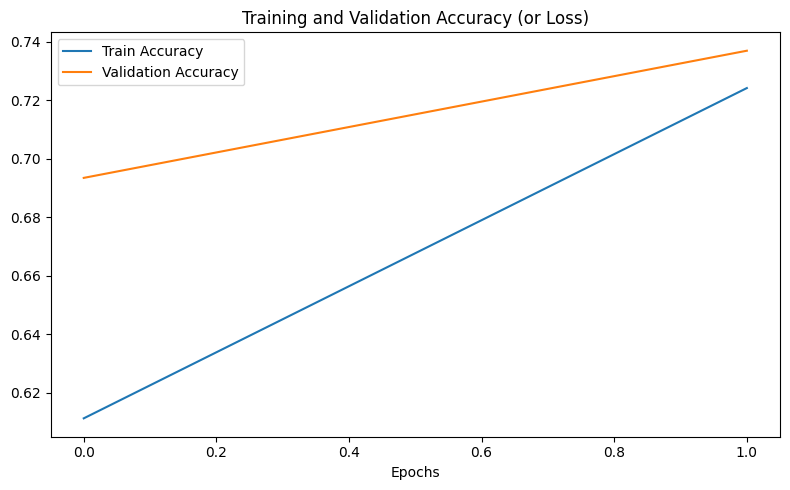

In [11]:
print("\n--- Plot Training History ---")
plot_training_history(history)

In [12]:
print("\n--- Predict Test Classes ---")
y_pred = model.predict(X_test_pad_filtered)
y_pred_classes = y_pred.argmax(axis=1)


--- Predict Test Classes ---
319/319 ━━━━━━━━━━━━━━━━━━━━ 26s 78ms/step



--- Generate Confusion Matrix ---


/mnt/c/grad_school/northeastern/ie7500/project/NLP_Project/src/emolex/evaluation.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


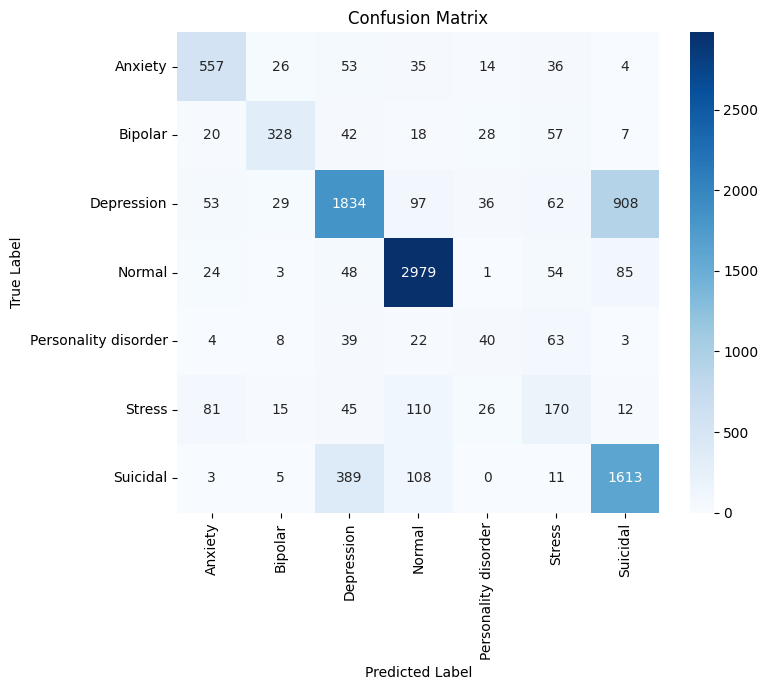

In [13]:
print("\n--- Generate Confusion Matrix ---")
fig, ax = generate_confusion_matrix(y_test_filtered, y_pred_classes, class_labels=encoder.classes_)

In [14]:
print("\n--- Generate Classification Report ---")
generate_classification_report(y_test_filtered, y_pred_classes, class_labels=encoder.classes_)


--- Generate Classification Report ---
                      precision    recall  f1-score   support

             Anxiety       0.75      0.77      0.76       725
             Bipolar       0.79      0.66      0.72       500
          Depression       0.75      0.61      0.67      3019
              Normal       0.88      0.93      0.91      3194
Personality disorder       0.28      0.22      0.25       179
              Stress       0.38      0.37      0.37       459
            Suicidal       0.61      0.76      0.68      2129

            accuracy                           0.74     10205
           macro avg       0.63      0.62      0.62     10205
        weighted avg       0.74      0.74      0.73     10205

